References:

**Alexandr Lipton and Marcos Lopez de Prado:** [ _"A closed-form solution for optimal mean-reverting trading strategies"_](https://ssrn.com/abstract=3534445)

**Marcos Lopez de Prado:**  [_"Advances in Financial Machine Learning"_](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089)

## Abstract

An Ornstein-Uhlenbeck process is a great tool for modeling the behavior of mean-reverting portfolio prices. Alexandr Lipton and Marcos Lopez de Prado present a methodology that allows to obtain a closed-form solution for the optimal mean-reverting trading strategies based on the OU model characteristics and the heat potential approach. The optimal trading rule, namely, optimal stop-loss and optimal profit-taking level are found by maximizing the approximated value of the Sharpe ratio.

## Data scaling

**NOTE:**
>In this approach we use the volume clock metric instead of the time-based metric. More on that in the paper
[**"The Volume Clock: Insights into the High Frequency Paradigm"**](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2034858) by David Easley, Marcos Lopez de Prado, and Maureen O'Hara


Let's presume an investment strategy S is a long investment strategy with p/l driven by the OU process:

$$dx' = \mu'(\theta'-x')dt'+\sigma'dW_{t'}, x'(0) = 0$$

and a trading rule $R = \{ \bar{\pi}',\underline{\pi}',T' \}$. To make the application of the method of heat potentials possible we transform it to use its steady-state by performing scaling to remove superfluous parameters.

$$t = \mu't',\ T = \mu'T',\ x = \frac{\sqrt{\mu'}}{\sigma'} x',\ \theta = \frac{\sqrt{\mu'}}{\sigma'} \theta',\ \bar{\pi} = \frac{\sqrt{\mu'}}{\sigma'} \bar{\pi}',
\ \underline{\pi} = \frac{\sqrt{\mu'}}{\sigma'} \underline{\pi}'$$

And get:
$$dx = (\theta-x)dt + dW_t, \ \bar{\pi}' \leq x \leq \underline{\pi},\ 0 \leq t \leq T$$

**NOTE:**

>Short strategy reverses the roles of ${\bar{\pi}',\underline{\pi}'}$:
>
>$-\underline{\pi}$ equals the profit taken when the price hits $\underline{\pi}$ and
>
>$-\bar{\pi}$ losses are incurred while price hits $-\bar{\pi}$




Hence, we can restrict ourself to case with $\theta \geq 0$.

## Sharpe ratio calculation

The calculation of the Sharpe ratio follows the four-step algorithm:
***
**Step 1: Define a calculation grid**

First of all we define the grid $\upsilon$ based on which we will perform our numerical calculation:

$$ 0=\upsilon_0<\upsilon_1<...<\upsilon_n=\Upsilon,\  \upsilon(t) = \frac{1 - e^{-2(T-t)}}{2}$$

**Step 2: Numerically calculate helper functions** $\bar{\epsilon}, \underline{\epsilon}, \bar{\phi}, \underline{\phi}$

We are going to use the classical method of heat potentials to calculate the SR.
As a preparation, in this step, we solve the two sets of Volterra equations by using the trapezoidal rule of integral calculation.

**Step 3: Calculate the values of** $\hat{E}(\Upsilon,\bar{\omega})$ **and** $\hat{F}(\Upsilon,\bar{\omega})$

We need to compute these functions at one point, which can be done by approximation of the integrals using the
trapezoidal rule:

$$\hat{E}(\Upsilon,\bar{\omega}) = \frac{1}{2} \sum_{i=1}^k(\underline{w}_{n,i}\underline{\epsilon}_i + \underline{w}_{n,i-1}\underline{\epsilon}_{i-1} + \bar{w}_{n,i}\bar{\epsilon}_i + \bar{w}_{n,i-1}\bar{\epsilon}_{i-1})(\upsilon_i - \upsilon_{i-1})$$

$$ \hat{F}(\Upsilon,\bar{\omega}) = \frac{1}{2} \sum_{i=1}^k(\underline{w}_{n,i}\underline{\phi}_i + \underline{w}_{n,i-1}\underline{\phi}_{i-1} + \bar{w}_{n,i}\bar{\phi}_i + \bar{w}_{n,i-1}\bar{\phi}_{i-1})(\upsilon_i - \upsilon_{i-1})$$

Where *w* are the weights.

**Step 4: calculate the SR using the obtained values**

The previously computed functions $\hat{E}(\Upsilon,\bar{\omega})$ and $\hat{F}(\Upsilon,\bar{\omega})$
are substituted into the following formula to calculate the Sharpe ratio.

$$SR = \frac{\hat{E}(\Upsilon,\bar{\omega}) - \frac{2(\bar{\omega}-\theta)}{ln(1-2\Upsilon)}}{\sqrt{\hat{F}(\Upsilon,\bar{\omega}) - (\hat{E}(\Upsilon,\bar{\omega}))^2 + \frac{4(\Upsilon + ln(1-2\Upsilon)(\bar{\omega}-\theta)\hat{E}(\Upsilon,\bar{\omega})}{(ln(1-2\Upsilon))^2}}}$$


***

To find the optimal thresholds for the data provided by the user we maximize the calculated SR with respect to
$\bar{\pi}\geq0,\underline{\pi}\leq0$**

## How to use the heat potentials module

This module gives the ability to calculate optimal values for stop-loss and profit-taking level to construct the trading rule.

Imports

In [1]:
from arbitragelab.optimal_mean_reversion import OrnsteinUhlenbeck
from arbitragelab.optimal_mean_reversion import HeatPotentials
import matplotlib.pyplot as plt
import numpy as np

Data preparation:

Let's generate the OU data sample to example the whole model usage cycle.

In [2]:
# Generating the sample OU data
ou_data = OrnsteinUhlenbeck()

data = ou_data.ou_model_simulation(n=1000, theta_given=0.03711, mu_given=65.3333,
                            sigma_given=0.3, delta_t_given=1/255)

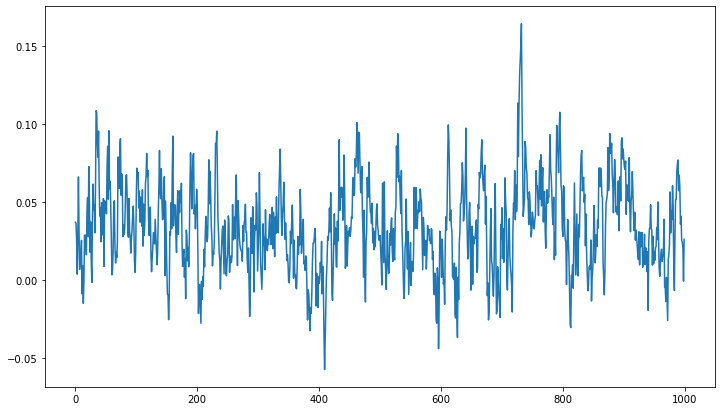

In [3]:
# Let's plot our data example
plt.figure(figsize=(12, 7))
plt.plot(data);

The next step would be to fit the OU model and obtain its parameters:

In [4]:
# To get the model parameters we need to fit the OU model to the data

# Assign the delta value
ou_data.delta_t = 1/252

# Model fitting
ou_data.fit_to_portfolio(data)

# Now we obtained the parameters to use for our optimization procedure
theta,mu,sigma = ou_data.theta,ou_data.mu,np.sqrt(ou_data.sigma_square)

In [5]:
# Printing out fitted parameters
print('theta:', round(theta,5), '\nmu:', round(mu,5), '\nsigma:', round(sigma,5))

theta: 0.03394 
mu: 72.0147 
sigma: 0.33929


Now we can perform the optimization process:

To fit the model and calculate optimal thresholds we need to provide:

* OU-model parameters that represent the data
* The grid density
* Maximum duration of the trade

In [6]:
# Establish the instance of the class
example = HeatPotentials()

# Fit the model and establish the maximum duration of the trade
example.fit(ou_params=(theta, mu, sigma), delta_grid=0.1, max_trade_duration=0.03)

Let's calculate the optimal levels and SR separately. 

To do so we can use the respective functions: 

In [7]:
# Calculate the initial optimal levels
levels = example.optimal_levels()

In [8]:
print('profit-taking threshold:', levels[0],
      '\nstop-loss threshold:', levels[1],
      '\nSharpe ratio:', levels[2])

profit-taking threshold: 5.091510252043523 
stop-loss threshold: -3.393771122195046 
Sharpe ratio: 1.069225115974827


While calculating the Sharpe ratio separately we will use the rounded values of the optimal threshold to showcase the sensitivity of the approach to small differences in values.

In [9]:
# We can also calculate the Sharpe ratio for given scaled parameters
sr = example.sharpe_calculation(max_trade_duration=1.9599, optimal_profit=5.07525, optimal_stop_loss=-3.41002)

print(sr,'\ndelta:', levels[2]-sr)

1.0417561181963706 
delta: 0.02746899777845635


To get scaled back results that correspond to our model parameters we use the description function.

In [10]:
# To get the results scaled back to our initial model we call the description function
example.description()

profit-taking threshold      0.203566
stop-loss level             -0.135688
max duration of the trade    0.030000
dtype: float64

## Conclusion

This notebook describes the heat-potential approach to finding optimal trading rules for mean-reverting strategies.

Key takeaways:
* Ornstein-Uhlenbeck model is used to model the behavior of mean-reverting assets.

* It is possible to use the heat potential approach on the financial data represented by an OU model.

* We formulate the problem for the long strategy, short strategy results can be obtained by reflection.

* The closed-form solution allows to formulate the optimization problem for calculating the optimal stop-loss and profit-taking thresholds.

* The model is sensitive to small changes in the given data.

## Reference
1.  Lipton, Alex and López de Prado, Marcos, A Closed-Form Solution for Optimal Mean-Reverting Trading Strategies (February 8, 2020). Available at SSRN: https://ssrn.com/abstract=3534445 or http://dx.doi.org/10.2139/ssrn.3534445 
2. Prado, Marcos Lopez de. Advances in Financial Machine Learning. Wiley, 2018.